In [25]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression

from jcopml.pipeline import num_pipe, cat_pipe
from jcopml.utils import save_model, load_model
from jcopml.plot import plot_missing_value, plot_confusion_matrix, plot_classification_report
from jcopml.feature_importance import mean_score_decrease
from jcopml.tuning import random_search_params as rsp

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from string import punctuation
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from gensim.models import Word2Vec, FastText

sw_indo = stopwords.words('indonesian') + list(punctuation)

# Import Data 

In [2]:
df = pd.read_csv('PRDECT-ID Dataset.csv')
df.head()

,Category,Product Name,Location,Price,Overall Rating,Number Sold,Total Review,Customer Rating,Customer Review,Sentiment,Emotion
0,Computers and Laptops,Wireless Keyboard i8 Mini TouchPad Mouse 2.4G ...,Jakarta Utara,53500,4.9,5449,2369,5,Alhamdulillah berfungsi dengan baik. Packaging...,Positive,Happy
1,Computers and Laptops,PAKET LISENSI WINDOWS 10 PRO DAN OFFICE 2019 O...,Kota Tangerang Selatan,72000,4.9,2359,1044,5,"barang bagus dan respon cepat, harga bersaing ...",Positive,Happy
2,Computers and Laptops,SSD Midasforce 128 Gb - Tanpa Caddy,Jakarta Barat,213000,5.0,12300,3573,5,"barang bagus, berfungsi dengan baik, seler ram...",Positive,Happy
3,Computers and Laptops,ADAPTOR CHARGER MONITOR LCD LED TV LG merek LG...,Jakarta Timur,55000,4.7,2030,672,5,bagus sesuai harapan penjual nya juga ramah. t...,Positive,Happy
4,Computers and Laptops,ADAPTOR CHARGER MONITOR LCD LED TV LG merek LG...,Jakarta Timur,55000,4.7,2030,672,5,"Barang Bagus, pengemasan Aman, dapat Berfungsi...",Positive,Happy


# Data Preprocessing 

### Data Cleaning

In [3]:
sum(df.isna().sum()) #Looking for null data

0

### Data Normalization

In [4]:
df['customer_review'] = df['Customer Review']
df.drop(columns='Customer Review', inplace=True)
df.head()

,Category,Product Name,Location,Price,Overall Rating,Number Sold,Total Review,Customer Rating,Sentiment,Emotion,customer_review
0,Computers and Laptops,Wireless Keyboard i8 Mini TouchPad Mouse 2.4G ...,Jakarta Utara,53500,4.9,5449,2369,5,Positive,Happy,Alhamdulillah berfungsi dengan baik. Packaging...
1,Computers and Laptops,PAKET LISENSI WINDOWS 10 PRO DAN OFFICE 2019 O...,Kota Tangerang Selatan,72000,4.9,2359,1044,5,Positive,Happy,"barang bagus dan respon cepat, harga bersaing ..."
2,Computers and Laptops,SSD Midasforce 128 Gb - Tanpa Caddy,Jakarta Barat,213000,5.0,12300,3573,5,Positive,Happy,"barang bagus, berfungsi dengan baik, seler ram..."
3,Computers and Laptops,ADAPTOR CHARGER MONITOR LCD LED TV LG merek LG...,Jakarta Timur,55000,4.7,2030,672,5,Positive,Happy,bagus sesuai harapan penjual nya juga ramah. t...
4,Computers and Laptops,ADAPTOR CHARGER MONITOR LCD LED TV LG merek LG...,Jakarta Timur,55000,4.7,2030,672,5,Positive,Happy,"Barang Bagus, pengemasan Aman, dapat Berfungsi..."


In [5]:
df['customer_review'] = df.customer_review.str.lower() #Lowercasing text data

# Exploratory Data Analysis 

C:\Users\RESTA\miniconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\RESTA\miniconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\RESTA\miniconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


Text(0.5, 1.0, 'Category-Emotion Distribution')

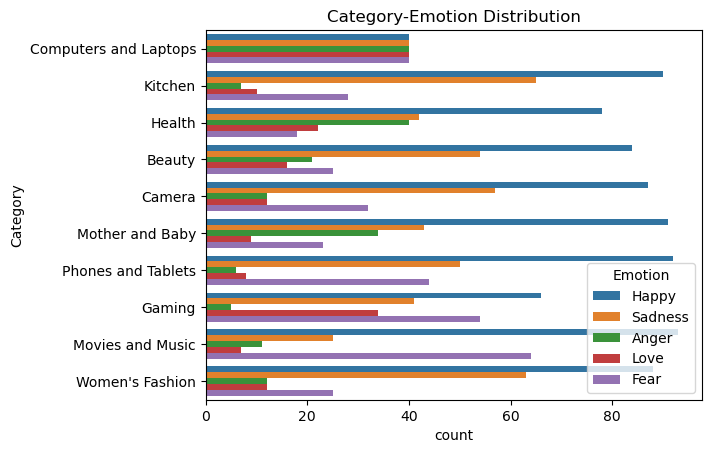

In [6]:
sns.countplot(y='Category', hue='Emotion', data=df, order=df.Category.value_counts().nlargest(10).index)
plt.title(label='Category-Emotion Distribution')

C:\Users\RESTA\miniconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\RESTA\miniconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\RESTA\miniconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


Text(0.5, 1.0, 'Location-Emotion Distribution')

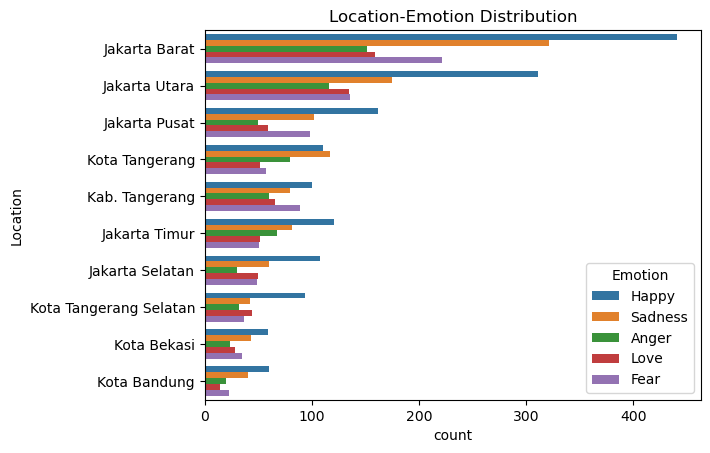

In [7]:
sns.countplot(y='Location', hue='Emotion', data=df, order=df.Location.value_counts().nlargest(10).index)
plt.title(label='Location-Emotion Distribution')

C:\Users\RESTA\miniconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\RESTA\miniconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\RESTA\miniconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\RESTA\miniconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is

<Axes: xlabel='Number Sold', ylabel='Price'>

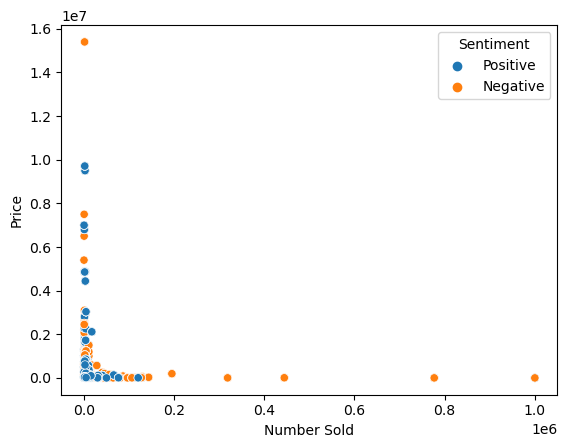

In [8]:
sns.scatterplot(x='Number Sold',y='Price', hue='Sentiment',data=df)

C:\Users\RESTA\miniconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\RESTA\miniconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\RESTA\miniconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\RESTA\miniconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is

Text(0.5, 1.0, 'Overall Rating-Emotion Distribution')

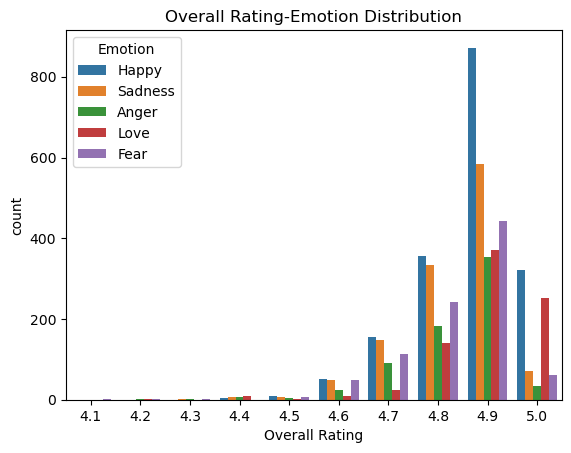

In [9]:
sns.countplot(x='Overall Rating', hue='Emotion', data=df)
plt.title(label='Overall Rating-Emotion Distribution')

C:\Users\RESTA\miniconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\RESTA\miniconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\RESTA\miniconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\RESTA\miniconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is

Text(0.5, 1.0, 'Customer Rating-Emotion Distribution')

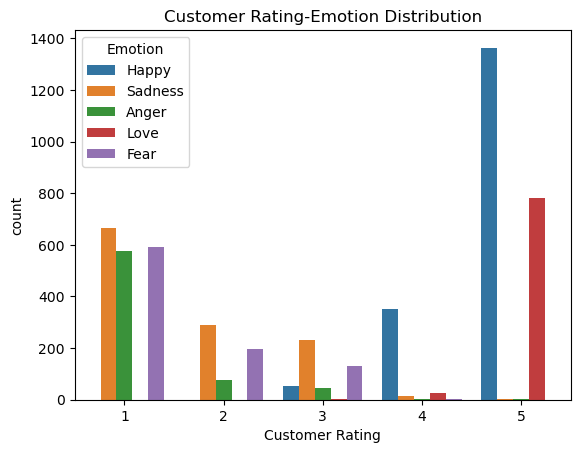

In [10]:
sns.countplot(x='Customer Rating', hue='Emotion', data=df)
plt.title(label='Customer Rating-Emotion Distribution')

C:\Users\RESTA\miniconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\RESTA\miniconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\RESTA\miniconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\RESTA\miniconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is

Text(0.5, 1.0, 'Total Review-Emotion Distribution')

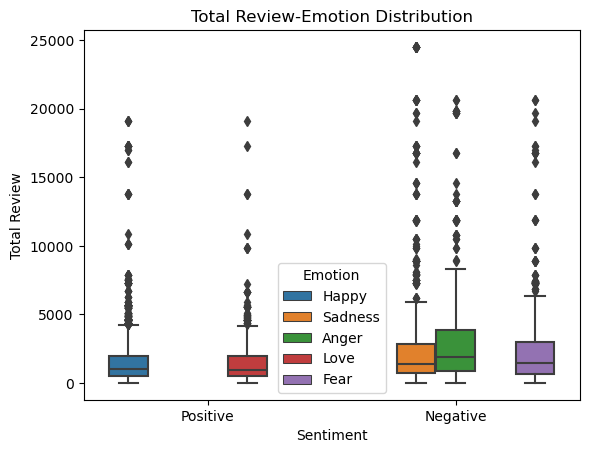

In [11]:
sns.boxplot(x='Sentiment', y='Total Review', data=df, hue='Emotion')
plt.title(label='Total Review-Emotion Distribution')

C:\Users\RESTA\miniconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\RESTA\miniconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\RESTA\miniconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\RESTA\miniconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is

Text(0.5, 1.0, 'Sentiment-Emotion Distribution')

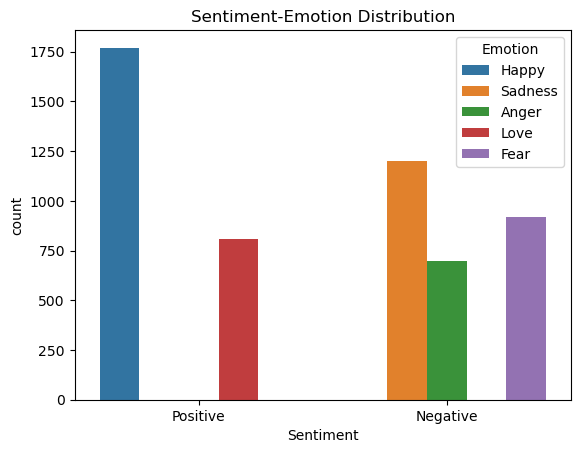

In [12]:
sns.countplot(x='Sentiment', hue='Emotion', data=df)
plt.title(label='Sentiment-Emotion Distribution')

### Feature Engineering

In [13]:
df.Sentiment.value_counts(normalize=True)

Sentiment
Negative    0.522407
Positive    0.477593
Name: proportion, dtype: float64

# Sentiment Analysis

### Dataset Splitting

In [14]:
X = df.customer_review
y = df.Sentiment

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((4320,), (1080,), (4320,), (1080,))

### Data Training 

In [15]:
pipeline = Pipeline([
    ('prep', TfidfVectorizer(tokenizer=word_tokenize, stop_words=sw_indo)),
    ('algo', LogisticRegression(solver='lbfgs', n_jobs=-1, random_state=42))
])

model = RandomizedSearchCV(pipeline, rsp.logreg_params, cv=3, n_iter=100, n_jobs=-1, verbose=1, random_state=42)
model.fit(X_train, y_train)

print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

Fitting 3 folds for each of 100 candidates, totalling 300 fits


C:\Users\RESTA\miniconda3\lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
C:\Users\RESTA\miniconda3\lib\site-packages\sklearn\feature_extraction\text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['``'] not in stop_words.
  warnings.warn(


{'algo__C': 6.688747907702067, 'algo__fit_intercept': True}
0.9872685185185185 0.9164351851851853 0.912962962962963


### Evaluation 

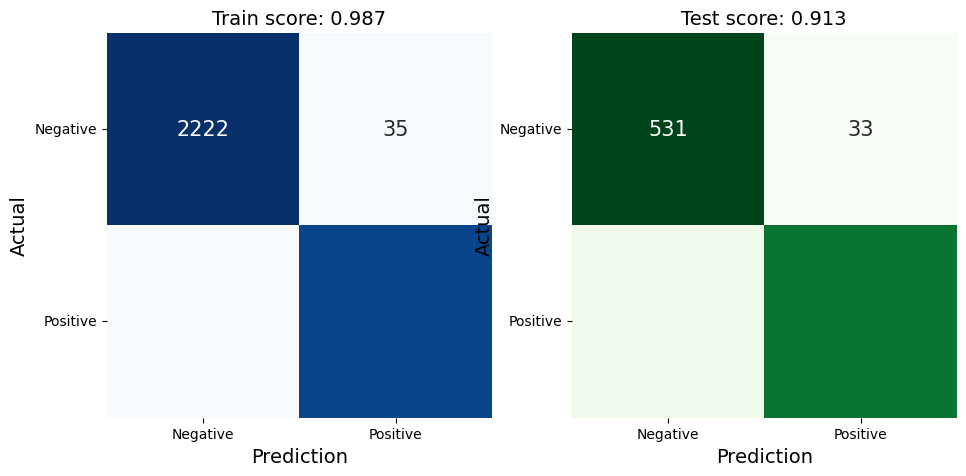

In [16]:
plot_confusion_matrix(X_train, y_train, X_test, y_test, model)

# Emoji Analysis 

### Dataset Splitting

In [17]:
X = df.customer_review
y = df.Emotion

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((4320,), (1080,), (4320,), (1080,))

### Data Training

In [18]:
pipeline = Pipeline([
    ('prep', TfidfVectorizer(tokenizer=word_tokenize, stop_words=sw_indo)),
    ('algo', LogisticRegression(solver='sag', multi_class='ovr', n_jobs=-1, random_state=42))
])

model = RandomizedSearchCV(pipeline, rsp.logreg_params, cv=3, n_iter=100, n_jobs=-1, verbose=1, random_state=42)
model.fit(X_train, y_train)

print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

Fitting 3 folds for each of 100 candidates, totalling 300 fits


C:\Users\RESTA\miniconda3\lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
C:\Users\RESTA\miniconda3\lib\site-packages\sklearn\feature_extraction\text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['``'] not in stop_words.
  warnings.warn(


{'algo__C': 3.919158240159647, 'algo__fit_intercept': True}
0.9171296296296296 0.5974537037037038 0.5944444444444444


### Evaluation

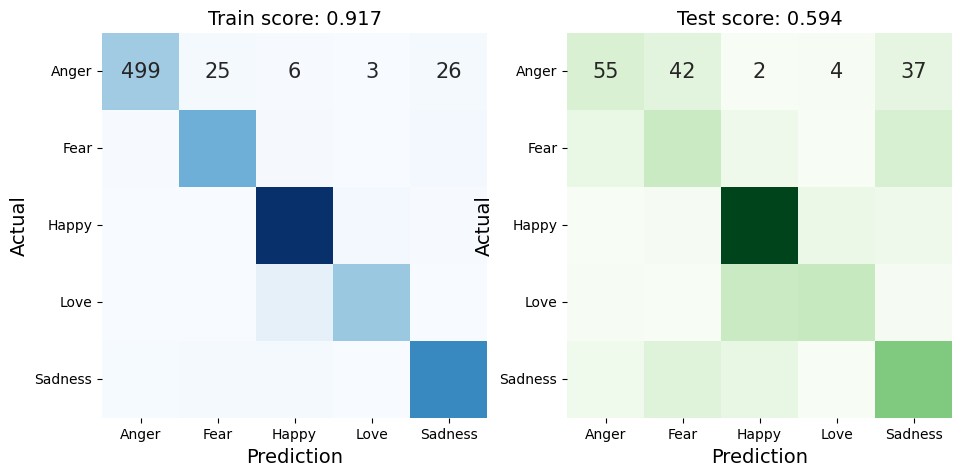

In [19]:
plot_confusion_matrix(X_train, y_train, X_test, y_test, model)

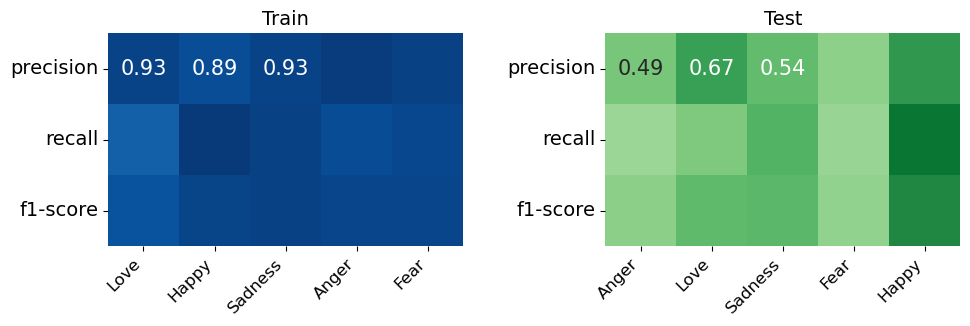

In [20]:
plot_classification_report(X_train, y_train, X_test, y_test, model)

In [39]:
df.Emotion.value_counts() #Lack of Data

Emotion
Happy      1770
Sadness    1202
Fear        920
Love        809
Anger       699
Name: count, dtype: int64